# SVM Regression (SVR / LinearSVR) — Chỉ dùng tập Train

## Bước 1 - Import các thư viện cần thiết
Import toàn bộ thư viện cần thiết cho SVM (SVR, LinearSVR, GridSearchCV, metrics, SGDRegressor).

Tạo các thư mục đầu ra

In [1]:
# Thư viện cơ bản
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor
import joblib

# Thư mục lưu hình
os.makedirs("../model/2_SVM_regression/results", exist_ok=True)
os.makedirs("../model/2_SVM_regression/saved_models", exist_ok=True)
RANDOM_STATE = 42

## Bước 2 - Đọc dữ liệu đã tiền xử lý (giống hệt notebook 3)

In [2]:
# Đọc dữ liệu
train_df = pd.read_csv('../data/processed/train.csv')
val_df = pd.read_csv('../data/processed/val.csv')
test_df = pd.read_csv('../data/processed/test.csv')

print("="*60)
print("THÔNG TIN DỮ LIỆU")
print("="*60)
print(f"Kích thước tập Train:      {train_df.shape}")
print(f"Kích thước tập Validation: {val_df.shape}")
print(f"Kích thước tập Test:       {test_df.shape}")
print("="*60)

# Hiển thị 5 dòng đầu của tập train
print("\n5 dòng đầu tiên của tập Train:")
train_df.head()

THÔNG TIN DỮ LIỆU
Kích thước tập Train:      (3255, 15)
Kích thước tập Validation: (1085, 15)
Kích thước tập Test:       (1085, 15)

5 dòng đầu tiên của tập Train:


,country_name,country_code,year,population,poverty_ratio,pop_growth,life_expectancy,gdp_per_capita,gdp_growth,sanitation,electricity,water_access,co2_emissions,slum_population,labor_force
0,Romania,ROU,2019,-0.103917,-0.597527,-1.127234,75.607317,-0.111538,0.095559,1.054465,0.619765,0.741985,-0.050517,-0.947687,-0.870988
1,Mauritius,MUS,2006,-0.242815,-0.693447,-0.510294,72.432195,-0.408990,0.257531,-0.109553,0.584429,0.713613,-0.227893,1.478783,-0.184739
2,Angola,AGO,2008,-0.087016,0.313714,1.546892,55.281000,-0.473931,1.341229,-0.870639,-1.553444,-2.267172,-0.441713,0.151208,1.614850
3,Albania,ALB,2001,-0.228830,-0.583978,-1.382935,75.083000,-0.587132,0.944795,-0.895734,0.598563,-0.027252,-0.413544,0.454933,-0.099440
4,Central African Republic,CAF,2021,-0.213116,2.687734,0.247317,40.279000,-0.621139,-0.409868,-1.390005,-2.359122,-3.005694,-0.539501,1.528277,1.186080


## Bước 3 - Chuẩn bị dữ liệu cho mô hình 

In [3]:
# Định nghĩa các cột đặc trưng (loại bỏ cột không cần thiết)
feature_cols = [col for col in train_df.columns 
                if col not in ['life_expectancy', 'country_name', 'country_code', 'year']]

# Tách X và y cho từng tập
X_train = train_df[feature_cols]
y_train = train_df['life_expectancy']

X_val = val_df[feature_cols]
y_val = val_df['life_expectancy']

X_test = test_df[feature_cols]
y_test = test_df['life_expectancy']

print("="*60)
print("THÔNG TIN CÁC TẬP DỮ LIỆU")
print("="*60)
print(f"Số lượng đặc trưng: {len(feature_cols)}")
print(f"\nCác đặc trưng được sử dụng:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

print(f"\nKích thước X_train: {X_train.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước X_val:   {X_val.shape}")
print(f"Kích thước y_val:   {y_val.shape}")
print(f"Kích thước X_test:  {X_test.shape}")
print(f"Kích thước y_test:  {y_test.shape}")
print("="*60)

THÔNG TIN CÁC TẬP DỮ LIỆU
Số lượng đặc trưng: 11

Các đặc trưng được sử dụng:
  1. population
  2. poverty_ratio
  3. pop_growth
  4. gdp_per_capita
  5. gdp_growth
  6. sanitation
  7. electricity
  8. water_access
  9. co2_emissions
  10. slum_population
  11. labor_force

Kích thước X_train: (3255, 11)
Kích thước y_train: (3255,)
Kích thước X_val:   (1085, 11)
Kích thước y_val:   (1085,)
Kích thước X_test:  (1085, 11)
Kích thước y_test:  (1085,)


## Bước 4 - Tối ưu LinearSVR bằng GridSearchCV (k=5)
Tìm cấu hình tốt nhất cho LinearSVR bằng 5-fold CV trên tập Train

In [4]:
# Lưới tham số cho LinearSVR
param_grid_linsvr = {
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.0, 0.1, 0.5],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'max_iter': [5000]
}
linsvr = LinearSVR(random_state=RANDOM_STATE, dual='auto')
cv_linsvr = GridSearchCV(linsvr, param_grid_linsvr, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
cv_linsvr.fit(X_train, y_train)
best_linsvr = cv_linsvr.best_estimator_
print("Best LinearSVR params:", cv_linsvr.best_params_)

# Đánh giá trên TRAIN
y_train_pred_linsvr = best_linsvr.predict(X_train)
linsvr_train_mse = mean_squared_error(y_train, y_train_pred_linsvr)
linsvr_train_r2  = r2_score(y_train, y_train_pred_linsvr)
print(f"LinearSVR | Train MSE: {linsvr_train_mse:.4f} | R2: {linsvr_train_r2:.4f}")

# Lưu model
joblib.dump(best_linsvr, "../model/2_SVM_regression/saved_models/linear_svr_best.pkl")

Best LinearSVR params: {'C': 10.0, 'epsilon': 0.0, 'loss': 'squared_epsilon_insensitive', 'max_iter': 5000}
LinearSVR | Train MSE: 17.4675 | R2: 0.7677


['../model/2_SVM_regression/saved_models/linear_svr_best.pkl']

## Bước 5 - Tối ưu SVR (kernel=rbf) bằng GridSearchCV (k=5)
Tối ưu SVR-RBF bằng 5-fold CV trên tập Train:

In [5]:
# Lưới tham số cho SVR (RBF)
param_grid_svr = {
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}
svr = SVR()
cv_svr = GridSearchCV(svr, param_grid_svr, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
cv_svr.fit(X_train, y_train)
best_svr = cv_svr.best_estimator_
print("Best SVR (RBF) params:", cv_svr.best_params_)

# Đánh giá trên TRAIN
y_train_pred_svr = best_svr.predict(X_train)
svr_train_mse = mean_squared_error(y_train, y_train_pred_svr)
svr_train_r2  = r2_score(y_train, y_train_pred_svr)
print(f"SVR (RBF) | Train MSE: {svr_train_mse:.4f} | R2: {svr_train_r2:.4f}")

# Lưu model
joblib.dump(best_svr, "../model/2_SVM_regression/saved_models/svr_rbf_best.pkl")

Best SVR (RBF) params: {'C': 10.0, 'epsilon': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}
SVR (RBF) | Train MSE: 9.3236 | R2: 0.8760


['../model/2_SVM_regression/saved_models/svr_rbf_best.pkl']

## Bước 6 - Vẽ Training Loss theo 10 epoch (SGDRegressor — Linear ε-SVR)
Trực quan hóa quá trình tối ưu của biến thể ε-SVR tuyến tính qua 10 epoch (Train) bằng SGDRegressor

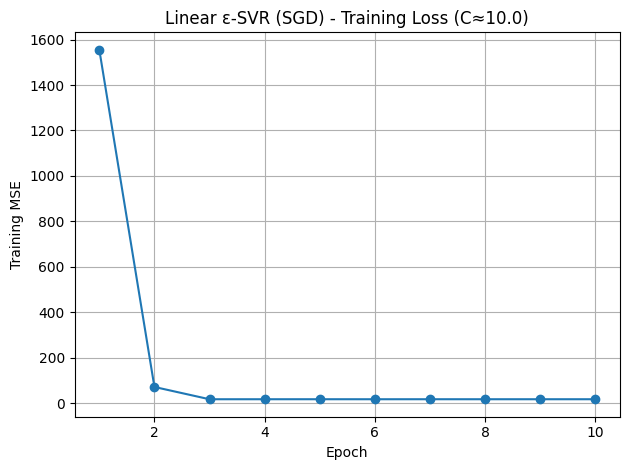

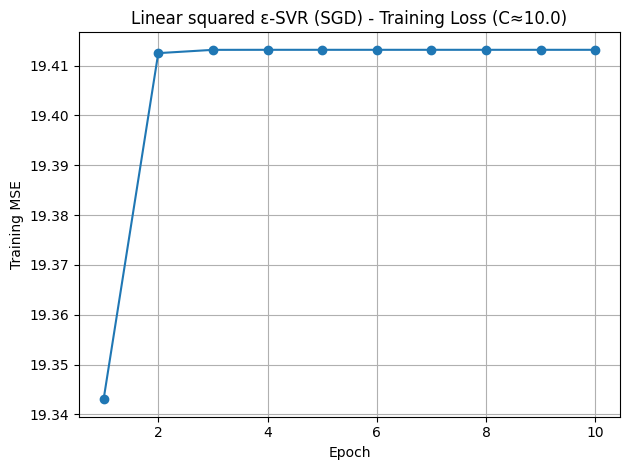

In [6]:
def plot_training_loss_sgd(X, y, loss, alpha, title, out_path, epochs=10, eta0=0.01, penalty='l2'):
    # loss: 'epsilon_insensitive' hoặc 'squared_epsilon_insensitive'
    sgd = SGDRegressor(loss=loss, penalty=penalty, alpha=alpha, learning_rate='constant',
                       eta0=eta0, max_iter=1, tol=None, random_state=RANDOM_STATE, warm_start=True)
    losses = []
    for epoch in range(epochs):
        sgd.fit(X, y)  # 1 epoch
        y_hat = sgd.predict(X)
        losses.append(mean_squared_error(y, y_hat))
    plt.figure()
    plt.plot(range(1, epochs+1), losses, marker='o')
    plt.xlabel('Epoch'); plt.ylabel('Training MSE'); plt.title(title)
    plt.grid(True); plt.tight_layout()
    plt.savefig(out_path, dpi=150); plt.show()
    return losses

# Lấy alpha xấp xỉ từ best C của LinearSVR (gợi ý: alpha ~ 1/(n*C))
n_train = len(X_train)
alpha_linsvr = 1.0 / (n_train * max(1e-8, cv_linsvr.best_params_['C']))

lin_ei_losses = plot_training_loss_sgd(
    X_train, y_train,
    loss='epsilon_insensitive', alpha=alpha_linsvr,
    title=f'Linear ε-SVR (SGD) - Training Loss (C≈{cv_linsvr.best_params_["C"]})',
    out_path='../model/2_SVM_regression/results/svm_linear_sgd_ei_loss.png',
    epochs=10, eta0=0.01, penalty='l2'
)

lin_sei_losses = plot_training_loss_sgd(
    X_train, y_train,
    loss='squared_epsilon_insensitive', alpha=alpha_linsvr,
    title=f'Linear squared ε-SVR (SGD) - Training Loss (C≈{cv_linsvr.best_params_["C"]})',
    out_path='../model/2_SVM_regression/results/svm_linear_sgd_sei_loss.png',
    epochs=10, eta0=0.01, penalty='l2'
)

## Bước 7 - Đường loss tham khảo cho biến thể tuyến tính (so sánh với SVR RBF)
Tạo đường loss tham chiếu bằng SGDRegressor tuyến tính với hệ số regularization suy ra từ C tốt nhất của SVR-RBF

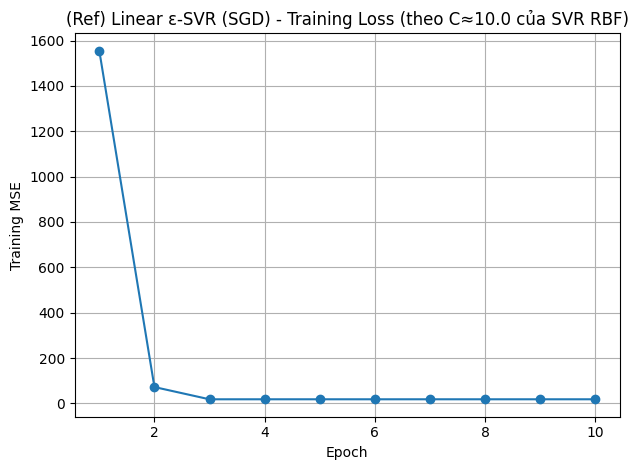

In [7]:
# SVR RBF không học theo epoch và không tuyến tính, nên chỉ vẽ đường loss SGD tuyến tính để tham khảo.
# Lấy alpha gần đúng từ best C của SVR RBF
alpha_svr_rbf = 1.0 / (n_train * max(1e-8, cv_svr.best_params_['C']))
rbf_ref_losses = plot_training_loss_sgd(
    X_train, y_train,
    loss='epsilon_insensitive', alpha=alpha_svr_rbf,
    title=f'(Ref) Linear ε-SVR (SGD) - Training Loss (theo C≈{cv_svr.best_params_["C"]} của SVR RBF)',
    out_path='../model/2_SVM_regression/results/svm_rbf_ref_linear_sgd_ei_loss.png',
    epochs=10, eta0=0.01, penalty='l2'
)

## Kết luận
Tổng hợp: tham số tốt nhất tìm được cho LinearSVR/SVR-RBF, và chỉ số Train (MSE, R²) của từng mô hình.

In [8]:
print("Hoàn tất: đã huấn luyện LinearSVR & SVR (RBF) với GridSearchCV 5-fold trên tập TRAIN,")
print("đồng thời vẽ training loss theo 10 epoch bằng SGDRegressor (ε-SVR tuyến tính) vào thư mục ../model/2_SVM_regression/results/.")

Hoàn tất: đã huấn luyện LinearSVR & SVR (RBF) với GridSearchCV 5-fold trên tập TRAIN,
đồng thời vẽ training loss theo 10 epoch bằng SGDRegressor (ε-SVR tuyến tính) vào thư mục ../model/2_SVM_regression/results/.
